<a href="https://colab.research.google.com/github/KillShotAK/UoS-Forex-Trading-Robot/blob/main/SentimentAnalysisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/150, Train Loss: 0.6591, Validation Loss: 0.3988, Train Accuracy: 68.75, Validation Accuracy: 83.68
Epoch 2/150, Train Loss: 0.3528, Validation Loss: 0.3492, Train Accuracy: 86.19, Validation Accuracy: 85.64
Epoch 3/150, Train Loss: 0.2265, Validation Loss: 0.3776, Train Accuracy: 91.50, Validation Accuracy: 84.69
Epoch 4/150, Train Loss: 0.1432, Validation Loss: 0.3855, Train Accuracy: 95.21, Validation Accuracy: 86.72
Epoch 5/150, Train Loss: 0.0937, Validation Loss: 0.4955, Train Accuracy: 96.88, Validation Accuracy: 85.23
Epoch 6/150, Train Loss: 0.0579, Validation Loss: 0.4551, Train Accuracy: 98.26, Validation Accuracy: 86.72
Epoch 7/150, Train Loss: 0.0557, Validation Loss: 0.4818, Train Accuracy: 98.06, Validation Accuracy: 86.65
Epoch 8/150, Train Loss: 0.0452, Validation Loss: 0.4765, Train Accuracy: 98.53, Validation Accuracy: 87.26
Epoch 9/150, Train Loss: 0.0334, Validation Loss: 0.5288, Train Accuracy: 98.85, Validation Accuracy: 85.30
Epoch 10/150, Train Loss: 0.

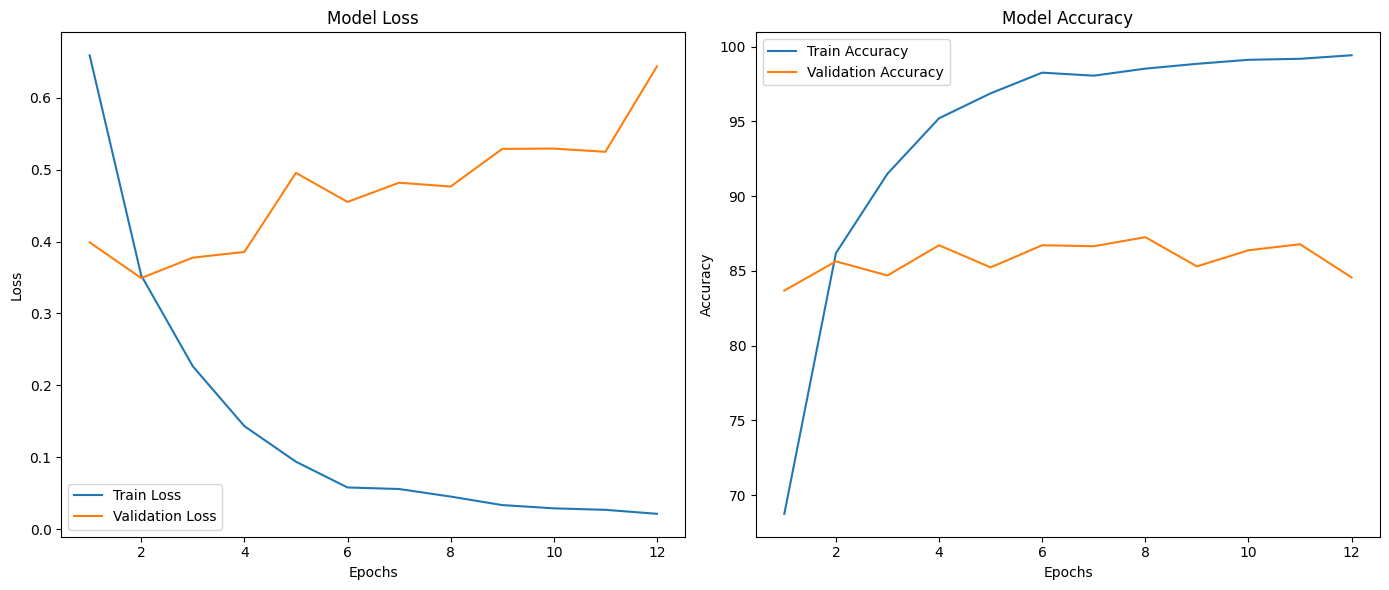

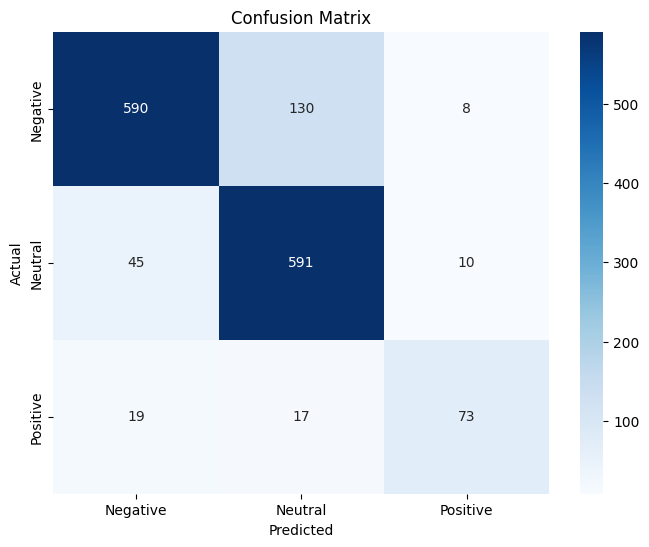


Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.81      0.85       728
     Neutral       0.80      0.91      0.85       646
    Positive       0.80      0.67      0.73       109

    accuracy                           0.85      1483
   macro avg       0.84      0.80      0.81      1483
weighted avg       0.85      0.85      0.84      1483



In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the data from pkl files
with open('/content/EURUSD_news_train (1).pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('/content/EURUSD_news_test (1).pkl', 'rb') as f:
    test_df = pickle.load(f)

# Prepare data for training
X_train = train_df['articleBody'].values
y_train = train_df['sentiment_label'].values.astype(int)
X_test = test_df['articleBody'].values
y_test = test_df['sentiment_label'].values.astype(int)

# Set up the model
model_name = "distilbert-base-uncased"  # Using distilbert as an example
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

# Tokenize data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# Convert to torch tensors
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(y_test)
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a custom model with ReLU activation
class CustomSentimentModel(nn.Module):
    def __init__(self, base_model):
        super(CustomSentimentModel, self).__init__()
        self.base_model = base_model
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(base_model.config.hidden_size, 3)  # Assuming 3 classes for sentiment

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token
        x = self.relu(hidden_state)
        logits = self.classifier(x)
        return logits

# Initialize custom model
model = CustomSentimentModel(base_model).to('cuda' if torch.cuda.is_available() else 'cpu')

# Training setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 150
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for batch in train_loader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, masks, labels = batch
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(running_loss / len(test_loader))
    val_acc.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}, Validation Accuracy: {val_acc[-1]:.2f}")

    # Early stopping
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        epochs_no_improve = 0
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load the best model
model.load_state_dict(best_model)

# Plotting loss and accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model(inputs, masks)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))
